# Modelo Preditivo de Inflação - AM

## Instalação e Importe de Pacotes

In [3]:
#!pip install python-bcb

  Attempting uninstall: anyio
    Found existing installation: anyio 2.2.0
    Uninstalling anyio-2.2.0:
      Successfully uninstalled anyio-2.2.0


In [50]:
#!pip install pmdarima

In [2]:
import sys
sys.path.insert(0, '..')
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from bcb import sgs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

## Importação da Base de Dados

In [20]:
df = sgs.get({'IPCA': 433}, start='1994-08-01')

In [21]:
df

,IPCA
Date,
1994-08-01,1.86
1994-09-01,1.53
1994-10-01,2.62
1994-11-01,2.81
1994-12-01,1.71
...,...
2021-10-01,1.25
2021-11-01,0.95
2021-12-01,0.73


## Visualização dos Dados

<AxesSubplot:xlabel='Date'>

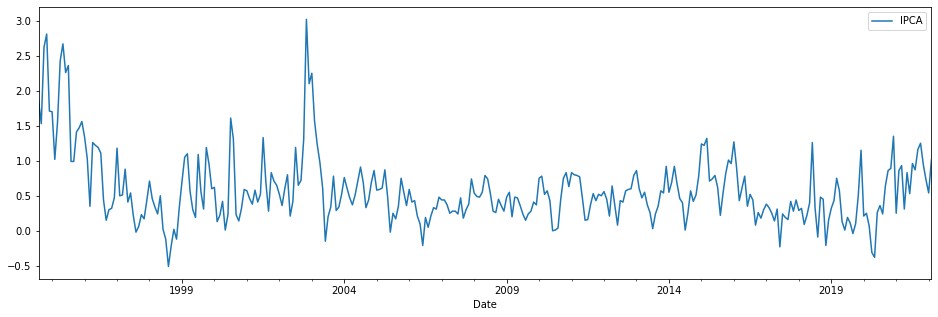

In [22]:
df.plot(figsize=(16, 5))

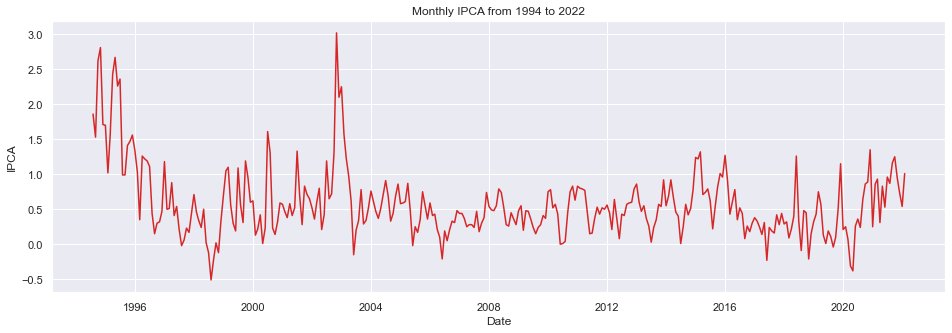

In [67]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='IPCA'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.IPCA, title='Monthly IPCA from 1994 to 2022')

In [36]:
rolling_mean = df.rolling(3).mean()
rolling_std = df.rolling(3).std()

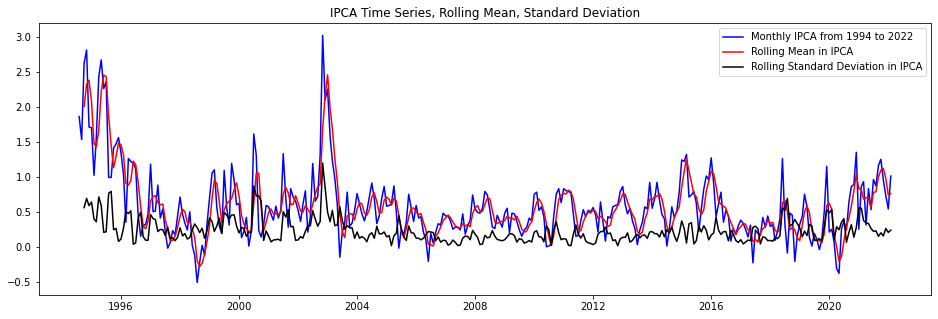

In [37]:
plt.figure(figsize=(16,5))
plt.plot(df, color="blue",label="Monthly IPCA from 1994 to 2022")
plt.plot(rolling_mean, color="red", label="Rolling Mean in IPCA")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in IPCA")
plt.title("IPCA Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

## Estacionariedade

In [38]:
adft = adfuller(df,autolag="AIC")

In [39]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -4.307169              Test Statistics
1    0.000432                      p-value
2   12.000000             No. of lags used
3  318.000000  Number of observations used
4   -3.451082          critical value (1%)
5   -2.870672          critical value (5%)
6   -2.571636         critical value (10%)


## Autocorrelação

In [41]:
autocorrelation_lag1 = df['IPCA'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
autocorrelation_lag3 = df['IPCA'].autocorr(lag=3)
print("Three Months Lag: ", autocorrelation_lag3)
autocorrelation_lag6 = df['IPCA'].autocorr(lag=6)
print("Six Months Lag: ", autocorrelation_lag6)
autocorrelation_lag9 = df['IPCA'].autocorr(lag=9)
print("Nine Months Lag: ", autocorrelation_lag9)

One Month Lag:  0.7346589138815792
Three Months Lag:  0.46391085644552654
Six Months Lag:  0.31913893220920053
Nine Months Lag:  0.33995995421984915


## Decomposição

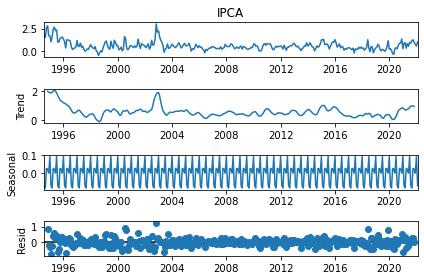

In [48]:
decompose = seasonal_decompose(df['IPCA'],model='additive', period=6)
decompose.plot()
plt.show()

## Previsão

Criando as bases de treinamento e de teste:

In [64]:
df[df['Date'] <= '2021-09-01']

,IPCA,Date
Date,,
1994-08-01,1.86,1994-08-01
1994-09-01,1.53,1994-09-01
1994-10-01,2.62,1994-10-01
1994-11-01,2.81,1994-11-01
1994-12-01,1.71,1994-12-01
...,...,...
2021-05-01,0.83,2021-05-01
2021-06-01,0.53,2021-06-01
2021-07-01,0.96,2021-07-01


<ipython-input-72-b4f103f715f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['IPCA']
<ipython-input-72-b4f103f715f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['IPCA']


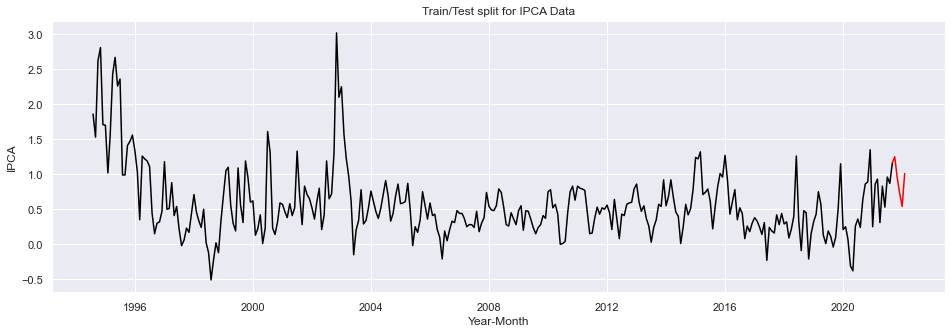

In [72]:
train = df[df['Date'] <= '2021-09-01']
train['train'] = train['IPCA']
del train['Date']
del train['IPCA']
test = df[df['Date'] >= '2021-09-01']
del test['Date']
test['test'] = test['IPCA']
del test['IPCA']
plt.figure(figsize=(16,5))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for IPCA Data")
plt.ylabel("IPCA")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [73]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=226.224, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=270.890, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=265.311, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=258.555, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=268.901, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=225.137, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=228.412, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=225.994, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=226.588, Time=1.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=227.149, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=225.756, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=229.131, Time=1.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=223.606, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=226.722, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=224.4

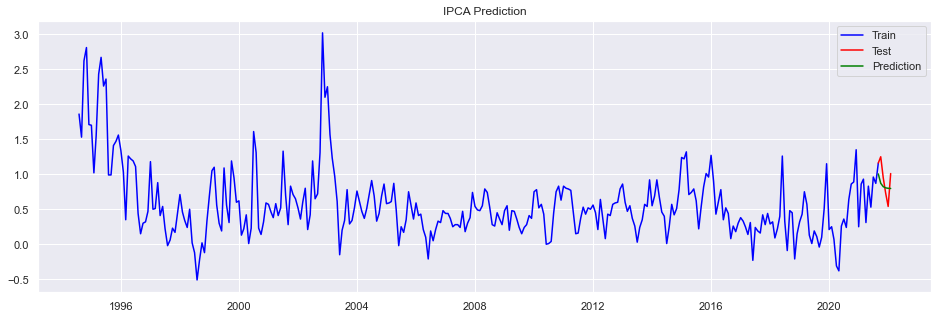

In [74]:
plt.figure(figsize=(16,5))
plt.plot(train, color="blue",label="Train")
plt.plot(test, color="red", label="Test")
plt.plot(forecast, color="green", label = "Prediction")
plt.title("IPCA Prediction")
plt.legend(loc="best")

In [76]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  0.22448851927100494
